# MontePetro

### Reservoir reserve estimates in Python

### Introduction

This package provides a library to perform basic monte carlo estimation of property distributions in native python.
The package was originaly intended to estimate oil and gas reserves in multi-regional domains
from petrophysical datasets, but can be applied to a variety of problems.

We will be performing a reservoir reserve estimate using the monte carlo method on an artificial 
reservoir property dataset. We will use MonePetro's built in functionality to compute the distributions and assemble the ensemble oil in place distribution for our model.

In [106]:
import matplotlib.pyplot as plot

from montepetro.models import Model
from montepetro.properties import RandomProperty
from montepetro.petroleum_properties import OriginalOilInPlace, ModelOriginalOilInPlace
from montepetro.regions import Region
from montepetro.visualization import *

### The Model container

MontePetro allows to create single and multi-region monte carlo estimates of parameter distributions. The basic container for all regions is provided by the model class.

In [107]:
seed = 300
model = Model("A simple reservoir model", seed)

The model contains regions as well as properties.
It also handles the generation of seed values for all the regional property distributions.
See the Model class documentation for more information.

Regions in MontePetro contain all of the properties of the model
and have their own distributional properties e.g. two different types of bone structure
in a larger bone could be modeled as two regions in a model.

We can perform calculations on the regions themselves or we can pass them to a model
structure and let the model do all the hard work for us!

In [108]:
region_a = Region(name="A", composition="Sandstone")
region_b = Region(name="B", composition="Carbonate")
region_c = Region(name="C", composition="Dolomite")

#For simplicity let's add these to our model
model.add_regions((region_a, region_b, region_c))

In [109]:
# region_a = Region(name="Region A", composition="Sandstone")
# region_b = Region(name="Region B", composition="Carbonate")
# region_c = Region(name="Region C", composition="Dolomite")

# #For simplicity let's add these to our model
# model.add_region(region_a)
# model.add_region(region_b)
# model.add_region(region_c)

MontePetro already comes with a number of properties types that we can define for our model.
RandomProperties are computed contain sets of values that we can sample from probability distributions.
RegionalProperties are properties that we want to calculate based on the defined properties of our model.

For our reservoir we want to estimate the oil in place distribution of our reservoir.
We define a simplistic oil in place as:

$$OilInPlace = Area*Height*NetToGross*Porosity(1-S_{w,irr})$$

Where we assume Height and NetToGross to be 1.
The following code goes into detail on how we create the probability distributions and add them to our model.

In [110]:
#Define number of samples we want to take
n = 100000

In [111]:
# We pass the RandomProperty our functions from which we sample the probability distributions
# Here we make use of the numpy libraries built in random number generators
# s = RandomProperty(name="Площадь", n=n, random_number_function='uniform')
# h = RandomProperty(name="Общая мощность", n=n, random_number_function="normal")
# hef = RandomProperty(name="Эффективная мощность", n=n, random_number_function="normal")
# poro = RandomProperty(name="Пористость", n=n, random_number_function="normal")
# s_o = RandomProperty(name="Нефтенасыщенность", n=n, random_number_function='triangular')
# s_w = RandomProperty(name="Водонасыщенность", n=n, random_number_function='triangular')
# ntg = RandomProperty(name="Коэффициент песчанистости", n=n, random_number_function='triangular')
# fvf = RandomProperty(name="Объемный коэффициент", n=n, random_number_function='triangular')
# per = RandomProperty(name="Объемный коэффициент", n=n, random_number_function='triangular') # =1/fvf
# den = RandomProperty(name="Плотность нефти", n=n, random_number_function='triangular')
# geomf = RandomProperty(name="Геометрический фактор", n=n, random_number_function='triangular')
# top_depth = RandomProperty(name="Кровля пласта", n=n, random_number_function='triangular')
# top_depth = RandomProperty(name="Подошва пласта", n=n, random_number_function='triangular')
# owc = RandomProperty(name="ВНК", n=n, random_number_function='triangular')
# gwc = RandomProperty(name="ГНК", n=n, random_number_function='triangular')

In [112]:
# #We pass the RandomProperty our functions from which we sample the probability distributions
# #Here we make use of the numpy libraries built in random number generators
area = RandomProperty(name="Area", num_samples=n, random_number_function="uniform")
porosity = RandomProperty(name="Porosity", num_samples=n, random_number_function="truncated normal")
sw = RandomProperty(name="Sw", num_samples=n, random_number_function="triangular")

In [113]:
#Let's add these to the model.
model.add_properties(
    {area: 'all', 
     porosity: 'all', 
     sw: 'all'}
)

In [114]:
# #Let's add these to the model.
# model.add_property(area, 'all')
# model.add_property(porosity, 'all')
# model.add_property(sw, 'all')

In [115]:
# # Lets add a fictional set of properties.
# config = {
#     "Region A": {
#         "Area": {"low": 100.0, "high": 1000.0},
#         "Porosity": {"low": 0.0, "high": 0.4812, "mean": 0.0929, "std": 0.0108},
#         "Sw": {"left": 0.00, "right": 0.15, "mode": 0.05},
#     },
#     "Region B": {
#         "Area": {"low": 20.0, "high": 200.0},
#         "Porosity": {"low": 0.0, "high": 0.4812, "mean": 0.1, "std": 0.1},
#         "Sw": {"left": 0.00, "right": 0.20, "mode": 0.10},
#     },
#     "Region C": {
#         "Area": {"low": 200.0, "high": 1000.0},
#         "Porosity": {"low": 0.0, "high": 0.4812, "mean": 0.08, "std": 0.02},
#         "Sw": {"left": 0.00, "right": 0.15, "mode": 0.05},
#     },
# }

In [116]:
a=0.0
b=0.4812
loc=0.08
scale=0.02

In [117]:
(a - loc) / scale, (b - loc) / scale

(-4.0, 20.06)

In [118]:
# Lets add a fictional set of properties.
config = {
    "A": {
        "Area": {"loc": 100.0, "scale": 900.0},
        "Porosity": {"a": -8.601851851851851, "b": 35.9537037037037, "loc": 0.0929, "scale": 0.0108},
        "Sw": {"loc": 0.00, "scale": 0.15, "c": 1/3},
    },
    "B": {
        "Area": {"loc": 20.0, "scale": 180.0},
        "Porosity": {"a": -1.0, "b": 3.812, "loc": 0.1, "scale": 0.1},
        "Sw": {"loc": 0.00, "scale": 0.20, "c": 1/2},
    },
    "C": {
        "Area": {"loc": 200.0, "scale": 800.0},
        "Porosity": {"a": -4.0, "b": 20.06, "loc": 0.08, "scale": 0.02},
        "Sw": {"loc": 0.00, "scale": 0.15, "c": 1/3},
    },
}

In [119]:
#Some Model container magic! We add all these properties to the regions.
# model.add_defined_properties_to_regions()

In [120]:
#We pass the model our configuration and run the model
#This will generate all the sampled distributions for each region
model.run(config)

### Calculating the oil in place for each region

To calculate the original oil in place for each region in the model, 
all we need to do is to add the regional property based on the OilInPlace property class.

In [121]:
model.add_regional_property("OOIP", OriginalOilInPlace)

### Calculating the model's oil in place

A similar approach is done for the model's oil in place.
We pass the model to the ModelOilInPlace class and MontePetro performs the analysis for us.

In [122]:
ooip = ModelOriginalOilInPlace(model)
save = ooip.run_calculation()

P90:  149.3711795485077 , P50:  103.67528605761102 , P10:  62.1251100535127


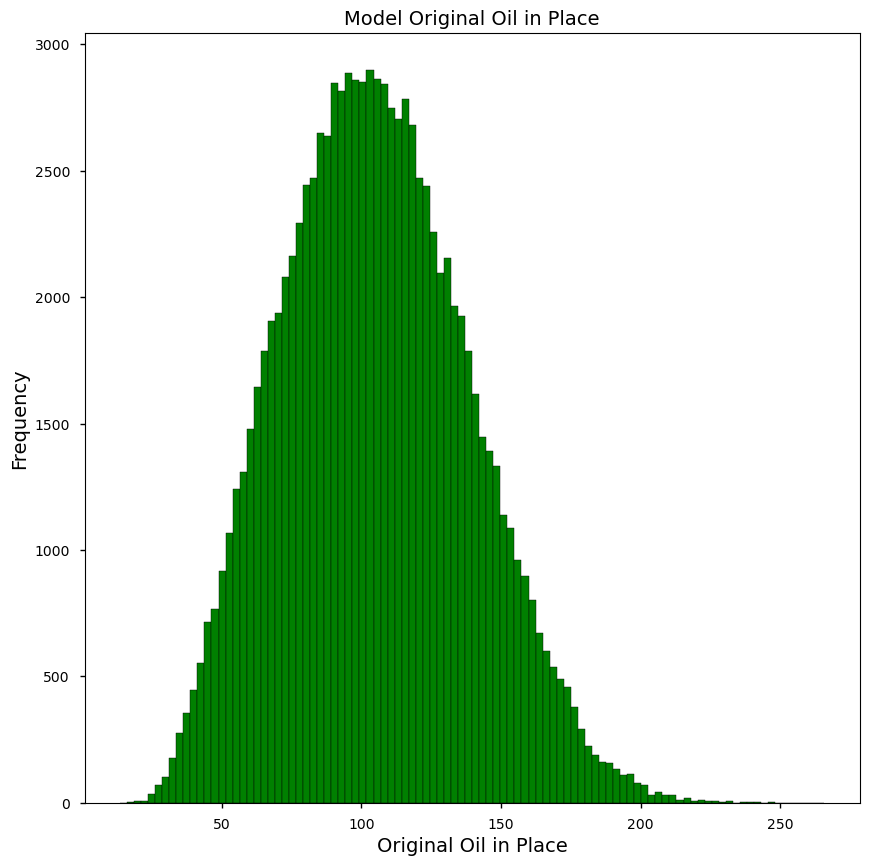

In [123]:
visualize_model_property(ooip, 100, fontsize=14)
print("P90: ", ooip.p10, ", P50: ", ooip.p50, ", P10: ", ooip.p90)

### Evaluating and plotting the results

We will now plot the input and output distributions for each region.

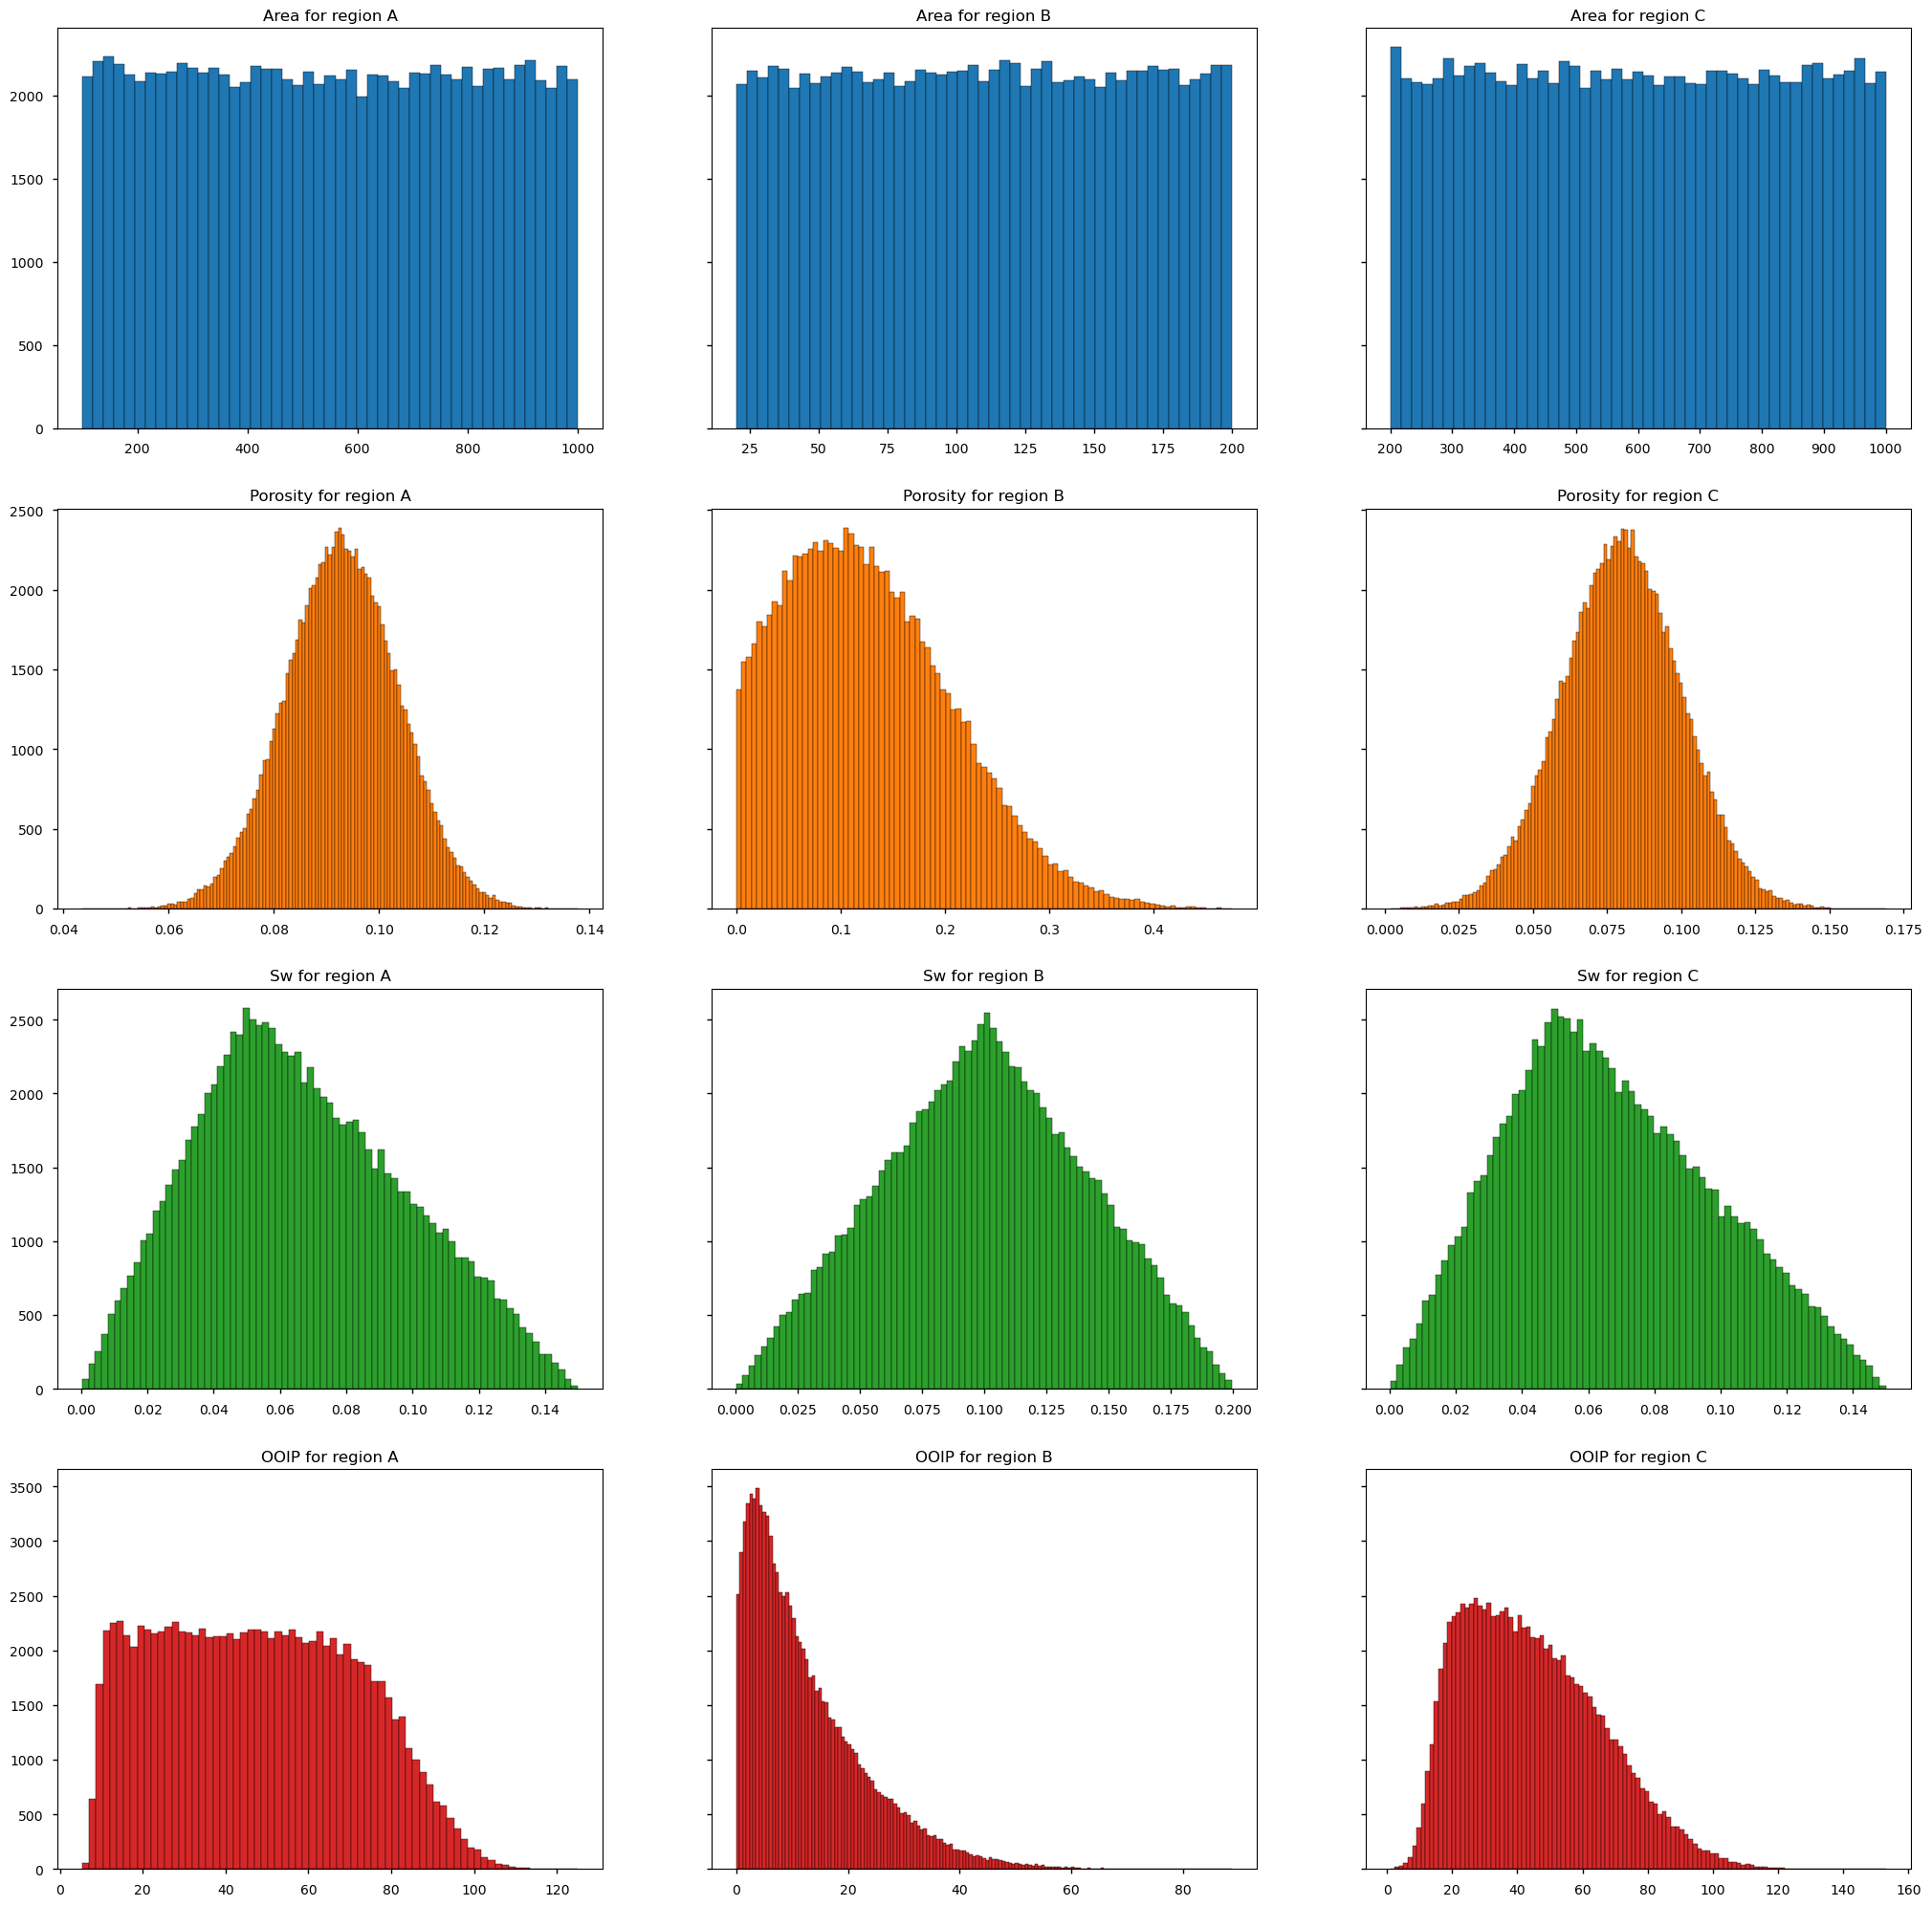

In [124]:
visualize_regional_distributions(model, figsize=(25, 25))